# Homework 12: Genetic Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils
from fractions import Fraction

from func import Func
from globalsearch import create_animation
from IPython.display import display, HTML

# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

plt.rc('animation', html='jshtml')

---
## Example 14.3


<img src="figures/homework-11/example-14.3.png" width="600" />














<img src="figures/homework-11/figure-14.10.png" width="600" />






















In [24]:
def create_f143():
    x1, x2 = sy.symbols('x1, x2')
    f = x1 * sy.sin(x1) + x2 * sy.sin(5*x2)
    return Func(f, (x1,x2))

f143 = create_f143()
f143

[x₁⋅sin(x₁) + x₂⋅sin(5⋅x₂)]

In [25]:
feasible_set = np.array([
    (0, 10), # Range of values for x1
    (4,  6)  # Range of values for x2
])
feasible_set

array([[ 0, 10],
       [ 4,  6]])

(<Figure size 864x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc3b48d7390>)

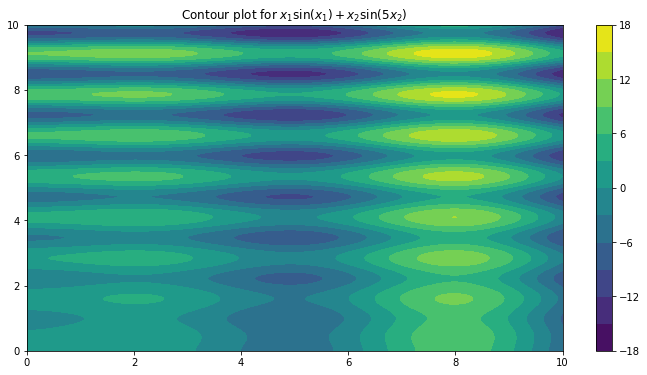

In [26]:
f143.plot_contour(x_limit=(0, 10))

In [28]:
class Chromosome:
    def __init__(self, x):
        self.x = x
        self.fitness = 0.0
        self.objective_value = 0.0
   
    def __repr__(self):
        return 'fitness={:3.4f} x={}'.format(float(self.fitness), utils.format_vector(self.x))

In [272]:
class RealNumberGeneticAlgorithm:
    def __init__(self, f, feasible_set):
        self._f = f
        self._feasible_set = np.array(feasible_set)

    def _create_initial_population(self, population_size):
        population = []
        
        # Compute the range of the random value for each entry
        low  = self._feasible_set[:,0]
        high = self._feasible_set[:,1]
        
        for i in range(population_size):
            # Generate points within the feasible set
            x = np.random.uniform(low, high)
            population.append(Chromosome(x))
        return population

    def objective_value(self, chromosome):
        return self._f.func_at(chromosome.x)[0]
    
    def _compute_fitness_and_objective_values(self, population):
        for individual in population:
            obj_val = self.objective_value(individual)
            individual.objective_value = obj_val

        # Ensure fitness values are non-negative
        obj_vals = np.array([i.objective_value for i in population])
        min_obj_val = obj_vals.min()
        incr = (-min_obj_val)+1 if min_obj_val < 0 else 0
        for individual in population:
            individual.fitness = individual.objective_value + incr

    def _select_mating_pool_roulette_wheel_scheme(self, population, pool_size):
        """
        Selects chromosomes into the mating pool with probabilities
        proportional to their fitness.
        """
        # Get the fitness values into an array
        fitness_array = np.array([i.fitness for i in population], dtype=np.float32)

        # Compute the selection probability for each individual
        selection_probabilities = fitness_array / fitness_array.sum()

        # Randomly select individuals with replacement (same individual may get selected multiple times)
        return np.random.choice(population, size=pool_size, p=selection_probabilities, replace=True)
    
    def _select_mating_pool_tournament_scheme(self, population, pool_size):
        """
        Selects chromosomes into the mating pool using the 
        tournament scheme where pairs of chromosomes are
        randomly selected from the population and the
        fittest chromosome end up in the mating pool.
        """
        mating_pool = []
        for i in range(pool_size):
            # Randomly select two chromosomes to fight
            chromo1, chromo2 = np.random.choice(population, size=2)

            if chromo1.fitness >= chromo2.fitness:
                mating_pool.append(chromo1)
            else:
                mating_pool.append(chromo2)

        return mating_pool
    
    def _crossover_by_averaging(self, mating_pool, offspring_size):
        offsprings = []
        for i in range(offspring_size):
            father, mother = np.random.choice(mating_pool, size=2)
            offspring = Chromosome((father.x + mother.x) / 2)
            offsprings.append(offspring)
        return offsprings
    
    def _crossover_random_vectors(self, mating_pool, offspring_size):
        offsprings = []
        iterations = int(offspring_size/2) + 1
        for i in range(iterations):
            father, mother = np.random.choice(mating_pool, size=2)
            r1 = np.random.normal(size=father.x.shape)
            r2 = np.random.normal(size=father.x.shape)
            z1 = (father.x + mother.x) / 2 + r1
            z2 = (father.x + mother.x) / 2 + r2
            # TODO: Ensure that x1 and x2 are in the feasible set
            offsprings.append(Chromosome(z1))
            offsprings.append(Chromosome(z2))
        # Since we crossover creates two offsprings in
        # each iteration, we are forced to kill off the
        # last offspring if the offspring_size is not even
        return offsprings[:offspring_size]
    
    def _crossover_by_convex_combination(self, mating_pool, offspring_size):
        offsprings = []
        iterations = int(offspring_size/2) + 1
        for i in range(iterations):
            father, mother = np.random.choice(mating_pool, size=2)

            # Find a random value in interval [0.0, 1.0)
            alpha = np.random.random_sample()

            # Compute convex combination
            z1 = alpha * father.x + (1 - alpha) * mother.x
            z2 = (1 - alpha) * father.x + alpha * mother.x

            offsprings.append(Chromosome(z1))
            offsprings.append(Chromosome(z2))
        # Since we crossover creates two offsprings in
        # each iteration, we are forced to kill off the
        # last offspring if the offspring_size is not even
        return offsprings[:offspring_size]
    
    def _mutate_by_random_vectors(self, population):
        """
        Mutates each individual in the population by adding
        a random vector
        """
        for individual in population:
            r = np.random.normal(size=individual.x.shape)
            individual.x += r
            # TODO: Ensure that x is in the feasible set
            
    def _mutate_by_convex_combination(self, population):
        """
        Mutates each individual in the population by
        random convex combination.
        """
        for individual in population:
            # Find a random value in interval [0.0, 1.0)
            alpha = np.random.random_sample()

            # Find a random point w
            w = np.random.normal(size=individual.x.shape)

            individual.x = alpha * individual.x  +  (1 - alpha) * w
            # TODO: Ensure that x is in the feasible set

    def _compute_stats(self, population):
        objective_vals = np.array([i.objective_value for i in population])
        best = objective_vals.max()
        avg = objective_vals.mean()
        worst = objective_vals.min()
        return best, avg, worst
    
    def _compute_fitness_stats(self, population):
        vals = np.array([i.fitness for i in population])
        return vals.max(), vals.mean(), vals.min()
            
    def run(self, population_size=20, max_generations=20):
        ret_val = {
            'best_objective_vals': [],
            'avg_objective_vals': [],
            'worst_objective_vals': [],
            'best_fitness_vals': [],
            'avg_fitness_vals': [],
            'worst_fitness_vals': []
        }
        population = self._create_initial_population(population_size)
        
        
        for k in range(1, max_generations+1):
            # Evaluate population
            self._compute_fitness_and_objective_values(population)
            
            # Compute statistics
            best, avg, worst = self._compute_stats(population)
            ret_val['best_objective_vals'].append(best)
            ret_val['avg_objective_vals'].append(avg)
            ret_val['worst_objective_vals'].append(worst)
            
            vals = np.array([i.fitness for i in population])
            print('k={} fit={}'.format(k, utils.format_vector(vals)))
            
            # Selection
            mating_pool = self._select_mating_pool_tournament_scheme(population, population_size)
            
            self._compute_fitness_and_objective_values(mating_pool)
            
            best, avg, worst = self._compute_fitness_stats(mating_pool)
            ret_val['best_fitness_vals'].append(best)
            ret_val['avg_fitness_vals'].append(avg)
            ret_val['worst_fitness_vals'].append(worst)
            
            # Crossover
            offsprings = self._crossover_by_convex_combination(mating_pool, population_size)
            
            # Mutation
            self._mutate_by_convex_combination(offsprings)
            
            population = offsprings
        return ret_val

In [273]:
def create_f143():
    x1, x2 = sy.symbols('x1, x2')
    f = x1 * sy.sin(x1) + x2 * sy.sin(5*x2)
    return Func(f, (x1,x2))

f143 = create_f143()
f143

[x₁⋅sin(x₁) + x₂⋅sin(5⋅x₂)]

In [274]:
feasible_set = np.array([
    (0, 10), # Range of values for x1
    (4,  6)  # Range of values for x2
])
feasible_set

array([[ 0, 10],
       [ 4,  6]])

In [275]:
rnga = RealNumberGeneticAlgorithm(f143, feasible_set)

In [276]:
num_generations = 20

In [277]:
result = rnga.run(max_generations=num_generations)

k=1 fit=['3.7744', '13.7127', '10.8087', '5.7614', '1.5342', '14.8026', '1.0000', '13.8093', '14.2493', '15.9549', '5.1593', '4.0742', '10.4604', '15.7065', '7.7614', '13.8627', '2.1745', '12.7910', '14.7258', '5.8579']
k=2 fit=['10.6386', '10.7321', '8.6776', '1.2715', '9.1571', '9.5801', '8.1860', '7.4462', '10.4908', '2.8511', '9.4439', '7.1584', '3.5679', '1.0000', '6.3171', '4.7019', '10.6630', '12.8657', '4.5170', '10.6732']
k=3 fit=['1.0000', '10.3175', '4.2537', '3.3057', '4.9281', '5.0116', '10.2721', '10.2196', '10.2197', '10.2778', '9.4969', '4.8502', '3.5252', '5.9846', '9.3244', '1.9147', '10.1995', '10.2196', '9.2610', '9.5313']
k=4 fit=['8.1431', '8.1431', '8.1882', '8.1438', '7.7690', '7.7828', '8.0452', '8.2968', '1.0000', '5.1730', '7.8526', '7.7389', '8.1859', '8.1443', '8.1833', '8.1449', '8.1426', '8.1235', '8.2858', '8.2976']
k=5 fit=['3.4965', '3.2279', '3.6823', '3.6823', '3.5284', '3.5284', '3.5283', '3.6834', '3.5761', '3.6205', '3.5542', '3.2567', '3.6863', '

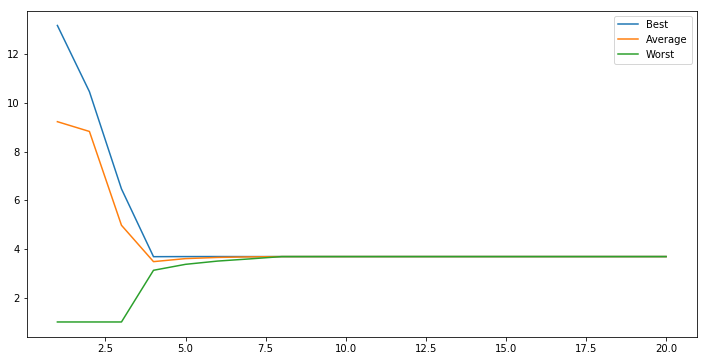

In [278]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(1, num_generations+1)
ax.plot(x, result['best_fitness_vals'], label='Best')
ax.plot(x, result['avg_fitness_vals'], label='Average')
ax.plot(x, result['worst_fitness_vals'], label='Worst')
ax.legend();

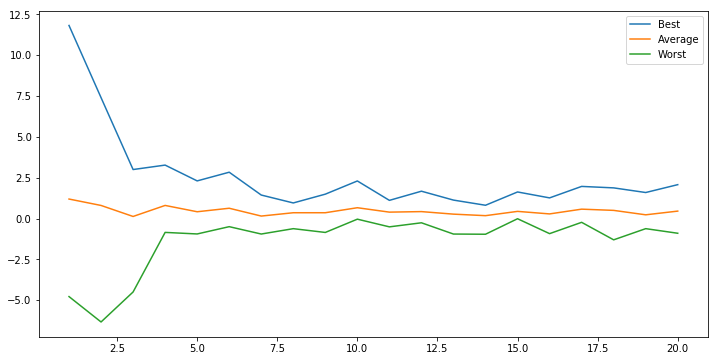

In [257]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(1, num_generations+1)
ax.plot(x, result['best_objective_vals'], label='Best')
ax.plot(x, result['avg_objective_vals'], label='Average')
ax.plot(x, result['worst_objective_vals'], label='Worst')
ax.legend();

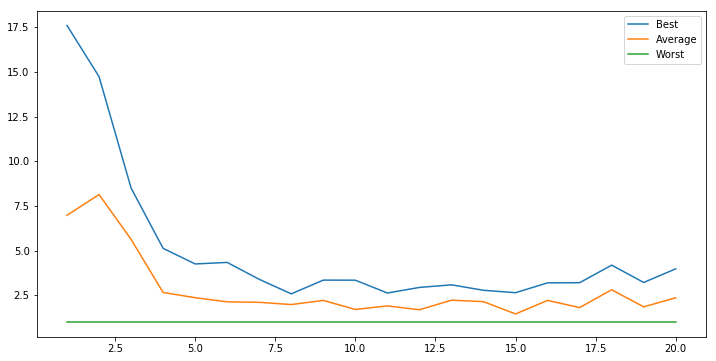

In [258]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(1, num_generations+1)
ax.plot(x, result['best_fitness_vals'], label='Best')
ax.plot(x, result['avg_fitness_vals'], label='Average')
ax.plot(x, result['worst_fitness_vals'], label='Worst')
ax.legend();

(<Figure size 864x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc3a05792b0>)

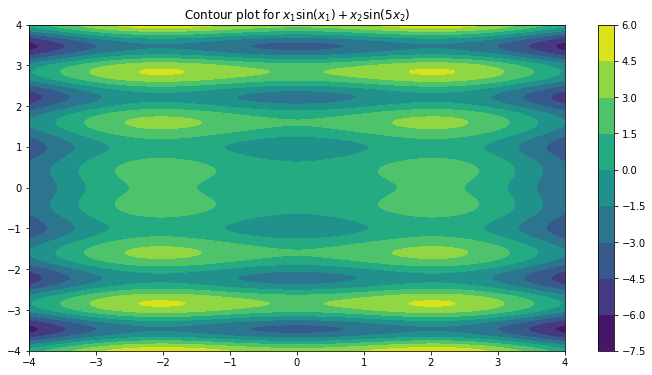

In [241]:
f143.plot_contour()